# Аналитика онлайн-продаж (Самокат)

В этом ноутбуке проводится анализ продаж товаров по данным из таблиц "products" и "orders".

**Цель** — выполнить набор аналитических задач: определить ходовые категории, изучить структуру продаж, рассчитать средний чек, промо-долю, маржу и провести ABC-анализ.

Импортируем необходимые для анализа библиотеки и настраиваем отображение графиков.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Настройки графиков
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Отображение всех колонок в pandas
pd.set_option('display.max_columns', None)

## **ШАГ 1**: Загружаем таблицы products и orders. Проводим первичный обзор имеющихся данных.

Задачи:
1. Загрузить таблицы products и orders
2. Привести типы данных, при необходимости
3. Проверить пропуски и дубликаты
4. Добавить поля, необходимые для дальнейшего анализа

In [2]:
# Пути к файлам
path_products = '../data/products.xlsx'
path_orders = '../data/orders.xlsx'

In [3]:
# Загрузка данных из Excel для products
products = pd.read_excel(path_products, engine='openpyxl')

products.head()

,product_id,level1,level2,name
0,1,Гигиена,Бритье,Кассеты для бритья Gillette Fusion ProGlide Po...
1,2,Мучные кондитерские изделия,Мучные кондитерские изделия,Печенье Бодрость
2,3,Мясная гастрономия,"Сосиски, сардельки",Сосиски Стародворье
3,4,Чай,Черный чай,Чай Азерчай
4,5,Безалкогольные напитки,Соковая продукция,Морс Valio


In [4]:
# Загрузка данных из Excel для orders
orders = pd.read_excel(path_orders, engine='openpyxl')

orders.head()

,order_id,accepted_at,product_id,quantity,regular_price,price,cost_price
0,1517514900,2022-01-13 16:48:19,17122,1,169,169,74
1,1517430051,2022-01-13 16:46:53,17122,1,169,169,74
2,1517578174,2022-01-13 18:12:30,17122,1,169,169,74
3,1517466327,2022-01-13 15:11:12,22199,1,219,219,130
4,1517429157,2022-01-13 19:15:59,22199,1,219,219,130


In [5]:
# Проверяем размеры и типы данных для products
print("Products shape:", products.shape)
print("\nProducts dtypes:")
print(products.dtypes)

Products shape: (40152, 4)

Products dtypes:
product_id     int64
level1        object
level2        object
name          object
dtype: object


In [6]:
# Проверяем размеры и типы данных для orders
print("Orders shape:", orders.shape)
print("\nOrders dtypes:")
print(orders.dtypes)

Orders shape: (3323, 7)

Orders dtypes:
order_id                  int64
accepted_at      datetime64[ns]
product_id                int64
quantity                  int64
regular_price             int64
price                     int64
cost_price                int64
dtype: object


In [7]:
# Создаём вспомогательные поля
orders['sales_qty'] = orders['quantity']
orders['sales_sum'] = orders['price'] * orders['quantity']


In [8]:
# Добавляем признак промо
orders['is_promo'] = orders['price'] != orders['regular_price']

orders.head()

,order_id,accepted_at,product_id,quantity,regular_price,price,cost_price,sales_qty,sales_sum,is_promo
0,1517514900,2022-01-13 16:48:19,17122,1,169,169,74,1,169,False
1,1517430051,2022-01-13 16:46:53,17122,1,169,169,74,1,169,False
2,1517578174,2022-01-13 18:12:30,17122,1,169,169,74,1,169,False
3,1517466327,2022-01-13 15:11:12,22199,1,219,219,130,1,219,False
4,1517429157,2022-01-13 19:15:59,22199,1,219,219,130,1,219,False


In [9]:
# Проверяем пропуски
print("Пропуски в products:")
print(products.isna().sum())

print("\nПропуски в orders:")
print(orders.isna().sum())

Пропуски в products:
product_id      0
level1          0
level2          0
name          212
dtype: int64

Пропуски в orders:
order_id         0
accepted_at      0
product_id       0
quantity         0
regular_price    0
price            0
cost_price       0
sales_qty        0
sales_sum        0
is_promo         0
dtype: int64


In [10]:
# Проверяем дубликаты
print("\nДубликаты:")
print("products duplicates:", products.duplicated().sum())
print("orders duplicates:", orders.duplicated().sum())


Дубликаты:
products duplicates: 0
orders duplicates: 0


### Результаты шага:
* Данные успешно загружены
* Добавлены технические поля
    * sales_qty — количество
    * sales_sum — сумма продажи
    * is_promo — признак промо
* Проверены пропуски и дубликаты

## **ШАГ 2**: Объединяем таблицы product и orders

Задачи:
1. Объединить таблицы orders и products
2. Убрать заказы с товарами, которых нет в products (кроме среднего чека)
3. Проверить, сколько строк потерялось
4. Подготовить итоговый датафрейм df, с которым будем работать дальше

In [11]:
# Объединяем таблицы: orders + products
df = orders.merge(products, on='product_id', how='left')

df.head()

,order_id,accepted_at,product_id,quantity,regular_price,price,cost_price,sales_qty,sales_sum,is_promo,level1,level2,name
0,1517514900,2022-01-13 16:48:19,17122,1,169,169,74,1,169,False,Рыбная гастрономия,Нерыбные продукты моря,Крабовые палочки Меридиан
1,1517430051,2022-01-13 16:46:53,17122,1,169,169,74,1,169,False,Рыбная гастрономия,Нерыбные продукты моря,Крабовые палочки Меридиан
2,1517578174,2022-01-13 18:12:30,17122,1,169,169,74,1,169,False,Рыбная гастрономия,Нерыбные продукты моря,Крабовые палочки Меридиан
3,1517466327,2022-01-13 15:11:12,22199,1,219,219,130,1,219,False,Сыры,Мягкие сыры,Сыр Самокат
4,1517429157,2022-01-13 19:15:59,22199,1,219,219,130,1,219,False,Сыры,Мягкие сыры,Сыр Самокат


In [12]:
# Проверяем, что все колонки на месте, включая ранее добавленные
df.columns

Index(['order_id', 'accepted_at', 'product_id', 'quantity', 'regular_price',
       'price', 'cost_price', 'sales_qty', 'sales_sum', 'is_promo', 'level1',
       'level2', 'name'],
      dtype='object')

In [13]:
# Проверяем, сколько товаров не нашлось в products
missing_products = df['level1'].isna().sum()
missing_products

np.int64(305)

In [14]:
# Фильтруем строки, где есть категория товара (для анализа категорий)
df = df[~df['level1'].isna()].copy()

df.shape

(3018, 13)

In [15]:
df[['product_id', 'level1', 'level2', 'sales_qty', 'sales_sum']].head()

,product_id,level1,level2,sales_qty,sales_sum
0,17122,Рыбная гастрономия,Нерыбные продукты моря,1,169
1,17122,Рыбная гастрономия,Нерыбные продукты моря,1,169
2,17122,Рыбная гастрономия,Нерыбные продукты моря,1,169
3,22199,Сыры,Мягкие сыры,1,219
4,22199,Сыры,Мягкие сыры,1,219


### Результаты шага:
* Таблицы orders и products объединены
* Все строки заказов сопоставлены с категориями товаров
* Строки с отсутствующими категориями удалены (создан отдельный dataframe)

## **ШАГ 3**: Выделяем самую ходовую товарную группу

Задачи:
1. Посчитать количество проданных штук по каждой категории level1
2. Вывести таблицу
3. Найти категорию-лидера
4. Построить читаемый bar-chart

In [16]:
# Группировка по категориям: сколько штук продано по каждой категории
category_sales = df.groupby('level1')['sales_qty'].sum().reset_index()

category_sales

,level1,sales_qty
0,Бакалея,239
1,Безалкогольные напитки,534
2,Бытовая химия,23
3,Гигиена,77
4,Детское питание,96
5,Детство (Гигиена и Уход),6
6,Замороженная продукция,175
7,Кондитерские изделия,138
8,Консервированные продукты,74
9,"Кофе, какао",21


In [17]:
# Сортируем полученный результат по количеству продаж
category_sales_sorted = category_sales.sort_values(by='sales_qty', ascending=False)
category_sales_sorted

,level1,sales_qty
1,Безалкогольные напитки,534
11,Молочная продукция,483
19,Свежие овощи,262
10,Кулинария,250
0,Бакалея,239
25,Хлеб и хлебобулочные изделия,218
21,Снэки,212
20,Свежие фрукты,184
6,Замороженная продукция,175
7,Кондитерские изделия,138


In [18]:
# Находим категорию-лидера, которая продавалась лучше всех
top_category = category_sales_sorted.iloc[0]
top_category

level1       Безалкогольные напитки
sales_qty                       534
Name: 1, dtype: object

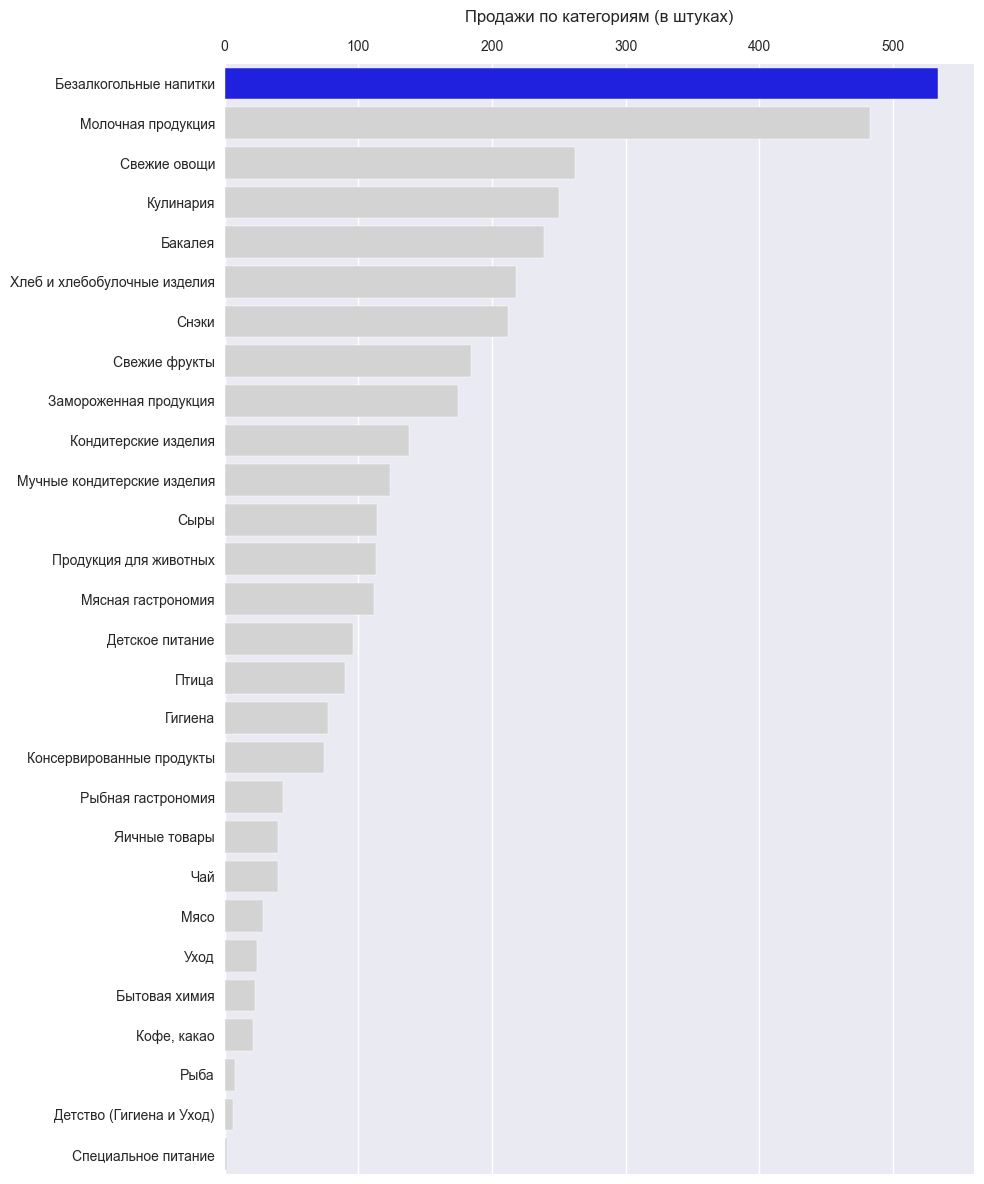

In [19]:
# 1. Находим категорию с максимальными продажами
max_category = category_sales_sorted.iloc[0]['level1']

# 2. Создаём цвета: максимальная категория — синий, остальные — серые
colors = [
    'blue' if cat == max_category else 'lightgray'
    for cat in category_sales_sorted['level1']
]

# 3. Преобразуем в словарь {категория: цвет}, чтобы не было FutureWarning
palette = dict(zip(category_sales_sorted['level1'], colors))

# 4. Строим график
plt.figure(figsize=(10, 12))
ax = sns.barplot(
    data=category_sales_sorted,
    y='level1',
    x='sales_qty',
    hue='level1',
    palette=palette,
    legend=False
)

# --- переносим ось X наверх ---
ax.xaxis.set_label_position('top')   # подпись оси X наверху
ax.xaxis.tick_top()                  # значения оси X наверху

# --- убираем названия осей ---
ax.set_xlabel('')
ax.set_ylabel('')

# --- заголовок ---
plt.title('Продажи по категориям (в штуках)', pad=30)

plt.tight_layout()
plt.show()



### Результаты шага:
* Наиболее ходовая категория - безалкогольные напитки
* Таблица показывает распределение количества проданных штук по всем категориям
* Barchart визуально подтверждает, что категория-лидер выделяется среди остальных

## **ШАГ 4**: Строим распределение продаж по подкатегориям

Задачи:
1. Посчитать, сколько штук продано в каждой подкатегории (level2) внутри каждой категории (level1).
2. Получить таблицу, по которой видно структуру продаж.

In [20]:
# 1. Группировка: продажи по категориям и подкатегориям
subcategory_sales = (
    df.groupby(['level1', 'level2'])['sales_qty']
      .sum()
      .reset_index()
)

# 2. Сортировка по количеству продаж
subcategory_sales_sorted = (
    subcategory_sales
    .sort_values(by='sales_qty', ascending=False)
)

# 3. Вывод таблицы
pd.set_option('display.max_rows', None)
subcategory_sales_sorted.head(10)

,level1,level2,sales_qty
13,Безалкогольные напитки,Напитки,252
54,Кулинария,Готовые блюда,248
95,Хлеб и хлебобулочные изделия,Хлеб и хлебобулочные изделия,218
86,Снэки,Снэки соленые,180
12,Безалкогольные напитки,Воды питьевые,162
78,Свежие овощи,"Корнеплоды, зелень и прочие овощи",157
60,Молочная продукция,Молоко и сливки,147
61,Молочная продукция,Молочно-десертные продукты,116
81,Свежие фрукты,"Цитрусовые, семечковые и прочие плоды",108
57,Молочная продукция,Кисломолочные традиционные продукты,106


### Результаты шага:
* Наибольший объём продаж в штуках пришёлся на подкатегории «Напитки», «Готовые блюда», «Хлебобулочные изделия» и «Снэки».
* В категории "Безалкогольные напитки" основную долю продаж дает подкатегория "Напитки"

## **ШАГ 5**: Считаем средний чек на дату 13.01.2022

Задача:
1. Определить, сколько в среднем тратил покупатель в указанный день

In [21]:
# Фильтр по дате 13 января 2022 года
date_filter = "2022-01-13"

orders_13 = orders[orders['accepted_at'].dt.date == pd.to_datetime(date_filter).date()]

orders_13.head()

,order_id,accepted_at,product_id,quantity,regular_price,price,cost_price,sales_qty,sales_sum,is_promo
0,1517514900,2022-01-13 16:48:19,17122,1,169,169,74,1,169,False
1,1517430051,2022-01-13 16:46:53,17122,1,169,169,74,1,169,False
2,1517578174,2022-01-13 18:12:30,17122,1,169,169,74,1,169,False
3,1517466327,2022-01-13 15:11:12,22199,1,219,219,130,1,219,False
4,1517429157,2022-01-13 19:15:59,22199,1,219,219,130,1,219,False


In [22]:
# Сумма чека = сумма продаж в рамках order_id
order_sums = orders_13.groupby('order_id')['sales_sum'].sum().reset_index()

order_sums.head()


,order_id,sales_sum
0,1517207363,795
1,1517288545,364
2,1517293568,1715
3,1517302077,2096
4,1517305540,342


In [23]:
# Считаем средний чек
average_check = order_sums['sales_sum'].mean()
print(f"Средний чек 13.01.2022: {average_check:.2f} ₽")

Средний чек 13.01.2022: 915.64 ₽


### Результаты шага:
* Средний чек составил 915.64 ₽
* Это средний объём расходов одного покупателя в выбранную дату.

## **ШАГ 6**: Расчитываем долю промо в категории "Сыры"

Задачи:
1. Определить, какая доля продаж в категории «Сыры» приходится на промо-акции
2. Построить pie-chart (круговую диаграмму)

In [24]:
# Делаем фильтр на категорию "Сыры"
cheese_df = df[df['level1'] == 'Сыры']
cheese_df.head()

,order_id,accepted_at,product_id,quantity,regular_price,price,cost_price,sales_qty,sales_sum,is_promo,level1,level2,name
3,1517466327,2022-01-13 15:11:12,22199,1,219,219,130,1,219,False,Сыры,Мягкие сыры,Сыр Самокат
4,1517429157,2022-01-13 19:15:59,22199,1,219,219,130,1,219,False,Сыры,Мягкие сыры,Сыр Самокат
5,1517416615,2022-01-13 10:39:06,22199,1,219,219,130,1,219,False,Сыры,Мягкие сыры,Сыр Самокат
6,1517577392,2022-01-13 11:50:14,22199,1,219,219,130,1,219,False,Сыры,Мягкие сыры,Сыр Самокат
64,1517374975,2022-01-13 12:42:34,2922,1,239,239,136,1,239,False,Сыры,Мягкие сыры,Сыр Страчателла Самокат


In [25]:
# Считаем продажи в штуках для промо-акции и не промо
promo_vs_regular = (
    cheese_df.groupby('is_promo')['sales_qty']
             .sum()
             .reset_index()
)

promo_vs_regular

,is_promo,sales_qty
0,False,79
1,True,35


In [27]:
# Считаем долю промо
promo_qty = promo_vs_regular.loc[promo_vs_regular['is_promo'] == True, 'sales_qty'].values[0]
total_qty = promo_vs_regular['sales_qty'].sum()

promo_share = promo_qty / total_qty
print(f"Доля промо в категории «Сыры»: {promo_share:.1%}")

Доля промо в категории «Сыры»: 30.7%


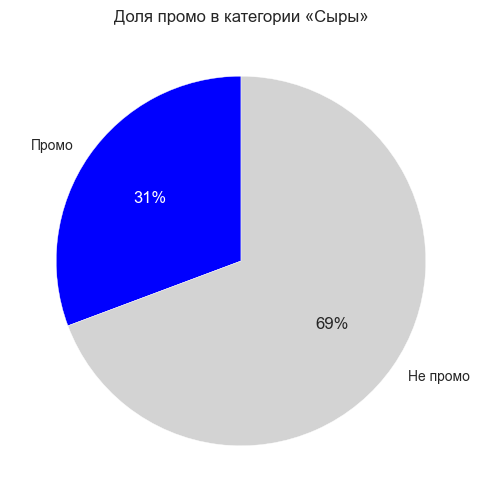

In [34]:
# Строим pie-chart
plt.figure(figsize=(6, 6))

labels = ['Промо', 'Не промо']
sizes = [
    promo_vs_regular.loc[promo_vs_regular['is_promo'] == True, 'sales_qty'].values[0],
    promo_vs_regular.loc[promo_vs_regular['is_promo'] == False, 'sales_qty'].values[0]
]

colors = ['blue', 'lightgray']

def format_pct(pct):
    return f'{pct:.0f}%'

wedges, texts, autotexts = plt.pie(
    sizes,
    labels=labels,
    autopct=format_pct,
    startangle=90,
    colors=colors
)

autotexts[0].set_color('white')

plt.title('Доля промо в категории «Сыры»')
plt.show()


### Результаты шага:

* Продано по промо: 35 шт
* Продано всего: 114 шт.
* Доля промо составляет: ~31%

## **ШАГ 7**: Считаем маржу по категориям (в рублях и процентах)

Задачи:
1. Посчитать маржу по каждой категории level1 (в рублях, в процентах)
2. Построить два горизонтальных bar-chart (маржа в рублях, маржа в процентах)

In [41]:
# Создаем поля маржи
df['margin_rub'] = (df['price'] - df['cost_price']) * df['sales_qty']
df['margin_pct'] = (df['price'] - df['cost_price']) / df['price'] * 100

df.head()

,order_id,accepted_at,product_id,quantity,regular_price,price,cost_price,sales_qty,sales_sum,is_promo,level1,level2,name,margin_rub,margin_pct
0,1517514900,2022-01-13 16:48:19,17122,1,169,169,74,1,169,False,Рыбная гастрономия,Нерыбные продукты моря,Крабовые палочки Меридиан,95,56.213018
1,1517430051,2022-01-13 16:46:53,17122,1,169,169,74,1,169,False,Рыбная гастрономия,Нерыбные продукты моря,Крабовые палочки Меридиан,95,56.213018
2,1517578174,2022-01-13 18:12:30,17122,1,169,169,74,1,169,False,Рыбная гастрономия,Нерыбные продукты моря,Крабовые палочки Меридиан,95,56.213018
3,1517466327,2022-01-13 15:11:12,22199,1,219,219,130,1,219,False,Сыры,Мягкие сыры,Сыр Самокат,89,40.639269
4,1517429157,2022-01-13 19:15:59,22199,1,219,219,130,1,219,False,Сыры,Мягкие сыры,Сыр Самокат,89,40.639269


In [43]:
# Агрегируем маржу по категориям
category_margin = (
    df.groupby('level1')
      .agg({
          'margin_rub': 'sum',
          'sales_sum': 'sum'
      })
      .reset_index()
)

# Маржа в процентах = сумма маржи / сумма выручки
category_margin['margin_pct'] = category_margin['margin_rub'] / category_margin['sales_sum'] * 100

category_margin

,level1,margin_rub,sales_sum,margin_pct
0,Бакалея,8177,21766,37.567766
1,Безалкогольные напитки,20373,46107,44.186349
2,Бытовая химия,1441,5478,26.305221
3,Гигиена,2971,10055,29.547489
4,Детское питание,1817,5091,35.690434
5,Детство (Гигиена и Уход),517,1729,29.901677
6,Замороженная продукция,13099,27714,47.264920
7,Кондитерские изделия,5918,13942,42.447282
8,Консервированные продукты,4154,10101,41.124641
9,"Кофе, какао",5059,9761,51.828706


In [46]:
# Сортируем категории по марже в рублях
category_margin_sorted_rub = category_margin.sort_values('margin_rub', ascending=False)

category_margin_sorted_rub


,level1,margin_rub,sales_sum,margin_pct
1,Безалкогольные напитки,20373,46107,44.186349
10,Кулинария,18452,40840,45.181195
6,Замороженная продукция,13099,27714,47.264920
11,Молочная продукция,12493,37582,33.241978
13,Мясная гастрономия,10230,24150,42.360248
21,Снэки,9582,22477,42.630244
19,Свежие овощи,9006,33222,27.108543
0,Бакалея,8177,21766,37.567766
20,Свежие фрукты,7879,27009,29.171758
23,Сыры,7474,19824,37.701776


In [47]:
# Сортируем категории по марже в процентах
category_margin_sorted_pct = category_margin.sort_values('margin_pct', ascending=False)

category_margin_sorted_pct

,level1,margin_rub,sales_sum,margin_pct
9,"Кофе, какао",5059,9761,51.828706
22,Специальное питание,208,410,50.731707
6,Замороженная продукция,13099,27714,47.264920
26,Чай,2929,6413,45.672852
12,Мучные кондитерские изделия,6283,13904,45.188435
10,Кулинария,18452,40840,45.181195
1,Безалкогольные напитки,20373,46107,44.186349
21,Снэки,9582,22477,42.630244
25,Хлеб и хлебобулочные изделия,6251,14724,42.454496
7,Кондитерские изделия,5918,13942,42.447282


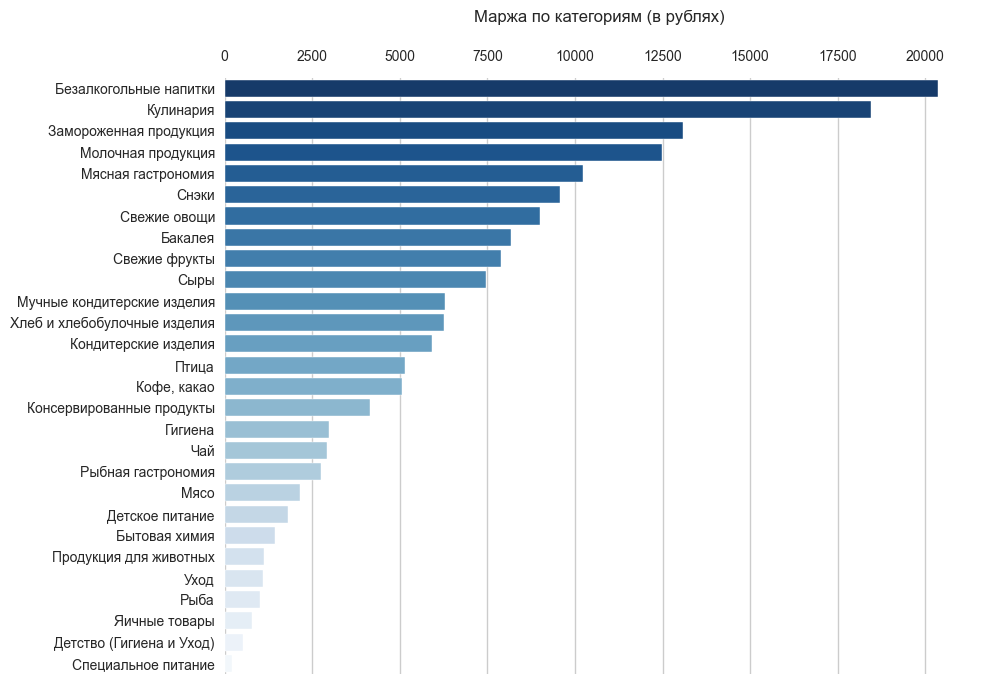

In [58]:
# Маржа по категориям в рублях
plt.figure(figsize=(10, 7))

sns.barplot(
    data=category_margin_sorted_rub,
    y='level1',
    x='margin_rub',
    hue='level1',
    palette='Blues_r',
    legend=False
)

plt.title('Маржа по категориям (в рублях)', pad=40)

plt.xlabel('')
plt.ylabel('')

plt.gca().xaxis.set_ticks_position('top')
plt.gca().xaxis.set_label_position('top')
plt.gca().tick_params(axis='x', pad=10)

plt.tight_layout()
plt.show()


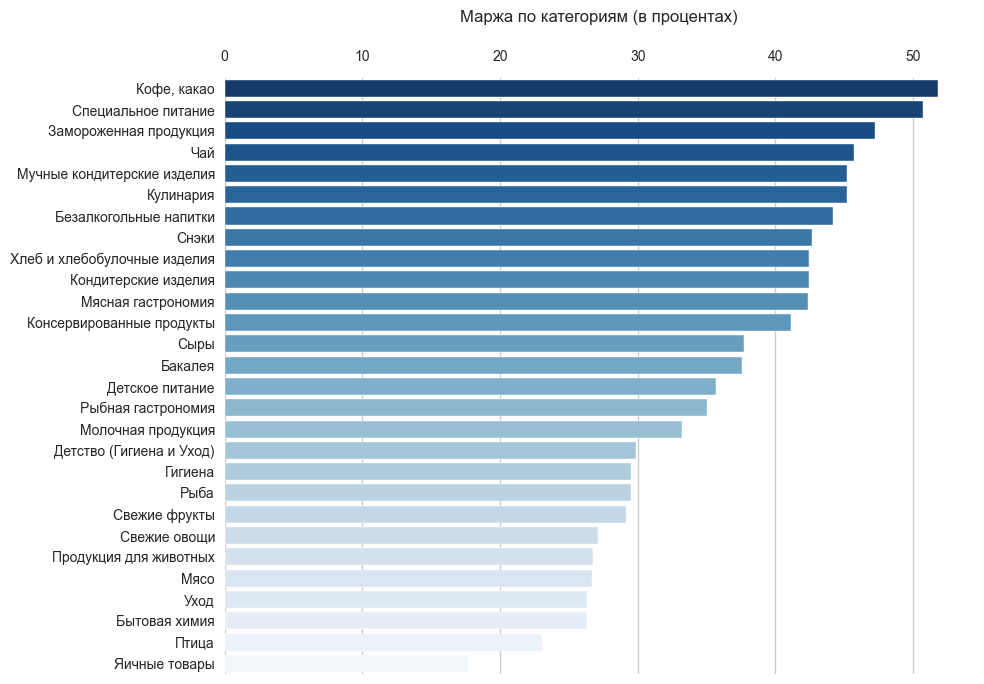

In [60]:
# Маржа по категориям в процентах
plt.figure(figsize=(10, 7))

sns.barplot(
    data=category_margin_sorted_pct,
    y='level1',
    x='margin_pct',
    hue='level1',
    palette='Blues_r'
)

plt.title('Маржа по категориям (в процентах)', pad=40)

plt.xlabel('')
plt.ylabel('')

plt.gca().xaxis.set_ticks_position('top')
plt.gca().xaxis.set_label_position('top')
plt.gca().tick_params(axis='x', pad=10)

plt.tight_layout()
plt.show()

### Результаты шага:

* Наибольшую маржу в абсолютных значениях дают категории: Безалкогольные напитки, Кулинария, Замороженная продукция
* Наибольшую относительную маржу (в процентах) имеют категории: Кофе/какао, Специальное питание, Замороженная продукция
* Категории с высокой маржей в рублях — ключевые драйверы прибыли.
* Категории с высокой маржей в процентах — хорошие кандидаты для премиализации и расширения ассортимента.

## **ШАГ 8**: ABC-анализ продаж по подкатегориям

Задачи:
1. Провести ABC-анализ по количеству проданного товара
2. Провести ABC-анализ по выручке
3. Вывести итоговые ABC-группы

In [63]:
# Проводим ABC-анализ по количеству продаж

# Группируем по подкатегориям
abc_qty = (
    df.groupby(['level1', 'level2'])['sales_qty']
      .sum()
      .reset_index()
)

# Сортируем по количеству (от большего к меньшему)
abc_qty = abc_qty.sort_values(by='sales_qty', ascending=False)

# Высчитываем долю каждой категории
total_qty = abc_qty['sales_qty'].sum()
abc_qty['share_qty'] = abc_qty['sales_qty'] / total_qty

# Считаем накопительную долю
abc_qty['cum_share_qty'] = abc_qty['share_qty'].cumsum()

# Присваиваем группы (A < 80%, B - 80-90%, С > 95%)
def assign_abc_group(cum_share):
    if cum_share <= 0.80:
        return 'A'
    elif cum_share <= 0.95:
        return 'B'
    else:
        return 'C'

abc_qty['abc_qty'] = abc_qty['cum_share_qty'].apply(assign_abc_group)

abc_qty.head()

,level1,level2,sales_qty,share_qty,cum_share_qty,abc_qty
13,Безалкогольные напитки,Напитки,252,0.067524,0.067524,A
54,Кулинария,Готовые блюда,248,0.066452,0.133976,A
95,Хлеб и хлебобулочные изделия,Хлеб и хлебобулочные изделия,218,0.058414,0.192390,A
86,Снэки,Снэки соленые,180,0.048232,0.240622,A
12,Безалкогольные напитки,Воды питьевые,162,0.043408,0.284030,A


In [64]:
# Проводим ABC-анализ по выручке

# Группируем по сумме
abc_rev = (
    df.groupby(['level1', 'level2'])['sales_sum']
      .sum()
      .reset_index()
)

# Сортируем от большего к меньшему
abc_rev = abc_rev.sort_values(by='sales_sum', ascending=False)

# Высчитываем долю продаж в выручке
total_rev = abc_rev['sales_sum'].sum()
abc_rev['share_rev'] = abc_rev['sales_sum'] / total_rev

# Считаем накопительную долю
abc_rev['cum_share_rev'] = abc_rev['share_rev'].cumsum()

# Присваиваем группы
abc_rev['abc_rev'] = abc_rev['cum_share_rev'].apply(assign_abc_group)

abc_rev.head()

,level1,level2,sales_sum,share_rev,cum_share_rev,abc_rev
54,Кулинария,Готовые блюда,40356,0.090322,0.090322,A
13,Безалкогольные напитки,Напитки,24123,0.053990,0.144312,A
72,Птица,Мясо птицы охлажденное,22349,0.050020,0.194332,A
79,Свежие овощи,"Тепличные овощи, грибы",18329,0.041023,0.235354,A
86,Снэки,Снэки соленые,17293,0.038704,0.274058,A


In [65]:
# Объединяем результаты двух анализов
abc_final = abc_qty.merge(
    abc_rev[['level1', 'level2', 'abc_rev']],
    on=['level1', 'level2'],
    how='left'
)

abc_final.head()

,level1,level2,sales_qty,share_qty,cum_share_qty,abc_qty,abc_rev
0,Безалкогольные напитки,Напитки,252,0.067524,0.067524,A,A
1,Кулинария,Готовые блюда,248,0.066452,0.133976,A,A
2,Хлеб и хлебобулочные изделия,Хлеб и хлебобулочные изделия,218,0.058414,0.192390,A,A
3,Снэки,Снэки соленые,180,0.048232,0.240622,A,A
4,Безалкогольные напитки,Воды питьевые,162,0.043408,0.284030,A,A


In [69]:
# Присваиваем итоговую группу
abc_final['abc_final'] = abc_final['abc_qty'] + ' ' + abc_final['abc_rev']

abc_final['abc_final']

0     A A
1     A A
2     A A
3     A A
4     A A
5     A A
6     A A
7     A A
8     A A
9     A A
10    A A
11    A A
12    A A
13    A A
14    A A
15    A B
16    A A
17    A A
18    A A
19    A B
20    A A
21    A B
22    A A
23    A A
24    A A
25    A A
26    A B
27    A B
28    A C
29    A C
30    B B
31    B A
32    B B
33    B A
34    B A
35    B A
36    B C
37    B B
38    B A
39    B B
40    B B
41    B B
42    B C
43    B B
44    B A
45    B B
46    B B
47    B B
48    B B
49    B C
50    B A
51    B A
52    B B
53    B B
54    B B
55    B B
56    B A
57    B B
58    C C
59    C C
60    C C
61    C B
62    C B
63    C B
64    C B
65    C C
66    C C
67    C C
68    C B
69    C B
70    C B
71    C B
72    C C
73    C C
74    C C
75    C C
76    C C
77    C C
78    C C
79    C C
80    C C
81    C C
82    C B
83    C C
84    C C
85    C C
86    C C
87    C C
88    C C
89    C C
90    C C
91    C C
92    C C
93    C C
94    C C
95    C C
96    C C
97    C C
98    C C
99    C C


### Результаты шага:

* Проведен ABC-анализ продаж по количеству и по сумме
* Итоговые группы определены